# README

Here are 4 parts in my program including data preprocessing, Model in normal binary dataset, Model in multi-class datatset, Model with dimension reduced dataset.</br>
How to run the code:</br>
Run the cell following sequence one by one, and here are some the exiting results I saved.</br>
Data Processing: read dataset and split them</br>
Model: ANN / KNN / Random Forest / Decision Tree</br>
Multi-class: ANN / KNN / Random Forest / Decision Tree</br>
Dimension Reduction: Random Forest / Decision Tree</br>


# Data Processing

In [1]:
import numpy as np
import random
import json



def read_data(file, x, y):
    data_lst = []
    lines = file.split('\n')

    for line in lines:
        row = [line.split(',')[0]]
        num = [int(line.split(',')[i]) for i in range(1, len(line.split(',')))]
        row.extend(num)
        if row[0] == x or row[0] == y:
            data_lst.append(row)

    data_length = int(len(data_lst) * 0.9)
    train_data = data_lst[0:data_length]
    test_data = data_lst[data_length:]
    return train_data, test_data


def data_process():
    with open('/content/drive/MyDrive/514_programming_2/data/letter-recognition.data') as f:
        file = f.read()

    train_dict = {}
    test_dict = {}
    all_train = []
    all_test = []

    label_lst = ["H", "M", "Z", "K", "Y", "J"]
    for i in range(0, len(label_lst)//2):
        label = label_lst[i] + label_lst[i+3]
        train_dict[label], test_dict[label] = read_data(file, label_lst[i], label_lst[i+3])
        all_train.extend(train_dict[label])
        all_test.extend(test_dict[label])

    random.shuffle(all_train)
    random.shuffle(all_test)

    train_dict['all_data'] = all_train
    test_dict['all_data'] = all_test

    return train_dict, test_dict



In [ ]:
import torch

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Model

## Artificial Neural Network

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as npc
from sklearn.model_selection import KFold
import time

In [ ]:
class ArtiModel(nn.Module):
    def __init__(self):
        super(ArtiModel, self).__init__()
        self.hidden1 = nn.Linear(16, 12)
        self.hidden2 = nn.Linear(12, 8)
        self.fc1 = nn.Linear(8, 2)
        # self.fc2 = nn.Linear(8, 6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.fc1(x)

        return x


def dataset(data_list):
    X = torch.tensor(np.array([i[1:] for i in data_list])).type(torch.FloatTensor)
    y = torch.tensor(np.array([i[0] for i in data_list])).type(torch.LongTensor)
    return X, y


def train(X, y, model, epoch):
    global optimizer
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0001)
    global loss_func
    loss_func = torch.nn.CrossEntropyLoss()

    t0 = time.time_ns()
    train_loss = 0

    for i in range(epoch):
        y_hat = model(X)
        # print(y_hat.shape)
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if i % 1000 == 0:
            print("step =", i, "loss =", loss.item())

    t1 = time.time_ns()
    total_time = t1-t0

    train_loss /= len(X)

    return train_loss, total_time

def test(X, y, model):
    model.eval()
    test_loss = 0
    acc = 0
    with torch.no_grad():
        y_hat = model(X)
        optimizer.zero_grad()
        test_loss += loss_func(y_hat, y).item()
        pred = y_hat.max(1, keepdim=True)[1]
        acc += pred.eq(y.view_as(pred)).sum().item()

        test_loss /= len(X)
        acc /= len(X)

    return acc

def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
      # print(i[0])
      i[0] = label_map[i[0]]

    return data_list



In [ ]:

def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
      # print(i[0])
      i[0] = label_map[i[0]]

    return data_list

if __name__ == '__main__':
    
    epoch = 2000
    train_dict, test_dict = data_process()
    label_lst = ["HK", "MY", "ZJ"]
    for i in label_lst:
        label = i
        # label = "HK"
        print(label)

        # model_file = '/content/drive/MyDrive/514_programming_2/model/AdamW/' + label + "_para.pkl"

        
        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        kf = KFold(n_splits=5, random_state=10, shuffle=True)

        for train_index, valid_index in kf.split(total_list):
            train_list = np.array(total_list)[train_index]
            valid_list = np.array(total_list)[valid_index]

            X_train, y_train = dataset(train_list)
            # print(y_train.shape)
            X_val, y_val = dataset(valid_list)
            # X_test, y_test = dataset(test_list)

            model = ArtiModel().to(device)
            # model.load_state_dict(torch.load(model_file))
            # model.eval()
            acc_lst = []

            X_train, y_train  = X_train.to(device), y_train.to(device)
            X_val, y_val = X_val.to(device), y_val.to(device)

            loss, total_time = train(X_train, y_train, model, epoch)
            acc = test(X_val, y_val, model)
            acc_lst.append(acc)
        
        

        # torch.save(model.state_dict(), model_file)
        print("acc:", np.mean(acc_lst))

# HK SGD Adam AdamW
# 0.939622641509434  0.981203007518797 0.9622641509433962
# MY 1.0 1.0 1.0 
# ZJ 0.981203007518797 1.0 0.9699248120300752

HK
step = 0 loss = 0.7228586077690125
step = 1000 loss = 0.07867196202278137
step = 0 loss = 0.7297458052635193
step = 1000 loss = 0.15923798084259033
step = 0 loss = 0.77169269323349
step = 1000 loss = 0.05837639421224594
step = 0 loss = 0.699889600276947
step = 1000 loss = 0.05656712129712105
step = 0 loss = 0.7104200124740601
step = 1000 loss = 0.05907526612281799
acc: 0.9547169811320755
MY
step = 0 loss = 0.7611786127090454
step = 1000 loss = 4.114154580747709e-05
step = 0 loss = 0.6824105381965637
step = 1000 loss = 3.2717605790821835e-05
step = 0 loss = 0.6950528621673584
step = 1000 loss = 7.814360287738964e-05
step = 0 loss = 0.858519434928894
step = 1000 loss = 2.8466569347074255e-05
step = 0 loss = 0.7077456116676331
step = 1000 loss = 6.39199060969986e-05
acc: 1.0
ZJ
step = 0 loss = 0.7498236894607544
step = 1000 loss = 0.0018585855141282082
step = 0 loss = 0.8660814762115479
step = 1000 loss = 0.03390059992671013
step = 0 loss = 0.960261881351471
step = 1000 loss = 0.000322

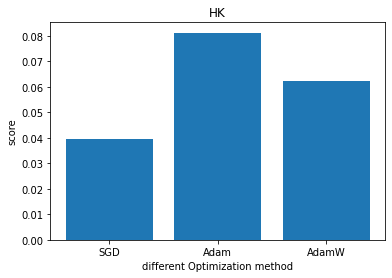

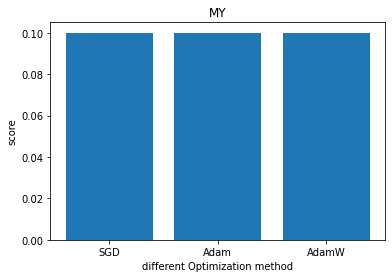

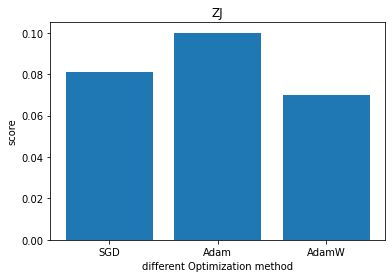

In [ ]:
# plot
import matplotlib.pyplot as plt
%matplotlib inline

label_lst = ["HK", "MY", "ZJ"]

Score_feature = [[0.939622641509434, 0.981203007518797, 0.9622641509433962], 
                 [1.0, 1.0, 1.0], [0.981203007518797, 1.0, 0.9699248120300752]]
deal_lst = [[i-0.9 for i in j] for j in Score_feature]

# print(deal_lst)
method_lst = ["SGD", "Adam", "AdamW"]

for i in range(0, 3):
  # print(i)
  label = label_lst[i]
  X = np.array(deal_lst[i])
  y = np.array(method_lst)
  plt.bar(y, X)
  plt.title(label)
  plt.xlabel('different Optimization method')
  plt.ylabel('score')
  plt.show()


In [ ]:
# For Test
import time


train_dict, test_dict = data_process()
label_lst = ["HK", "MY", "ZJ"]
Accuracy = {}
for i in label_lst:
    start_time = time.time()
    acc=0
    label = i
    print(label)

    checkpoint_file = '/content/drive/MyDrive/514_programming_2/model/Adam/' + label + "_para.pkl"
    checkpoint = torch.load(checkpoint_file) 
    model = ArtiModel().to(device)
    model.load_state_dict(checkpoint)

    train_dict, test_dict = data_process()
    test_list = test_dict[label]
    test_list = map_label(test_list)
    test_list = np.array(test_list)

    X_test, y_test = dataset(test_list)
    X_test, y_test = X_test.to(device), y_test.to(device)
    acc = test(X_test, y_test, model)

    Accuracy[label] = acc

    end_time = time.time()
    duration = end_time - start_time
    print(duration)  

print(Accuracy)

# {'HK': 0.918918918918919, 'MY': 0.9936708860759493, 'ZJ': 0.9865771812080537}  2.201439380645752
# {'HK': 0.9527027027027027, 'MY': 1.0, 'ZJ': 0.9932885906040269} 3.574378490447998
# {'HK': 0.9391891891891891, 'MY': 1.0, 'ZJ': 1.0}  2.7048752307891846



HK
0.8029649257659912
MY
0.5681371688842773
ZJ
0.560133695602417
{'HK': 0.9527027027027027, 'MY': 1.0, 'ZJ': 0.9932885906040269}


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
import operator
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
        i[0] = label_map[i[0]]

    return data_list


def dataset(data_list):
    X = np.array([i[1:] for i in data_list])
    y = np.array([i[0] for i in data_list])
    return X, y


class KNN:
    def __init__(self,k, X, y):
        self.k = k
        self.X = np.array(X)
        self.y = np.array(y)

    def get_para(self, x, y):
        x = np.array(x)
        y = np.array(y)
        return x, y

    def data_diatance(self, x_test, x_train):
        distances = np.sqrt(sum((x_test - x_train) ** 2))
        return distances

    def score(self, predict_result_set, y_test):
        count = 0
        for i in range(0, len(predict_result_set)):
            if predict_result_set[i] == y_test[i]:
                count += 1

        score = count / len(predict_result_set)

        return score

    def fit(self, x_test, y_test):
        x_test, y_test = self.get_para(x_test, y_test)

        predict = []
        train_length = len(self.X)
        distances = np.array(np.zeros(train_length))

        for i in x_test:
            for indx in range(train_length):
                distances[indx] = self.data_diatance(i, self.X[indx])

            sorted_dist = np.argsort(distances)
            label_dist = {}

            for i in range(self.k):
                sort_label = self.y[sorted_dist[i]]
                label_dist[sort_label] = label_dist.get(sort_label, 0) + 1


            sorted_label = sorted(label_dist.items(), key=operator.itemgetter(1), reverse=True)
            predict.append(sorted_label[0][0])
            score = self.score(predict, y_test)

        return score

HK


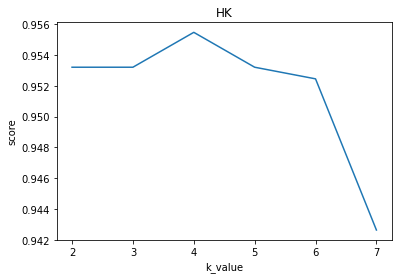

The best K is ： 4
MY


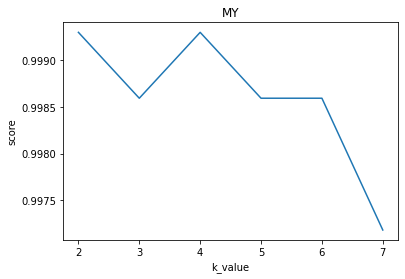

The best K is ： 2
ZJ


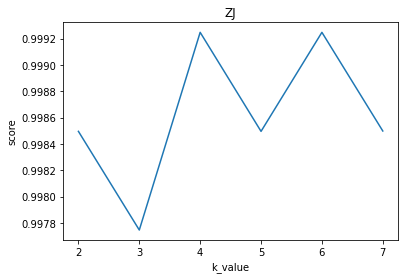

The best K is ： 4


In [ ]:
if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["HK", "MY", "ZJ"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        kf = KFold(n_splits=5, random_state=10, shuffle=True)
        cross_score_lst = []
        k_lst = []

        for k in range(2, 8):
            scores_lst = []
            for train_index, valid_index in kf.split(total_list):
                train_list = np.array(total_list)[train_index]
                valid_list = np.array(total_list)[valid_index]

                X_train, y_train = dataset(train_list)
                X_val, y_val = dataset(valid_list)

                knn = KNN(k=k, X=X_train, y=y_train)
                cross_score = knn.fit(X_val, y_val)
                scores_lst.append(cross_score)
                # print(cross_score)
            score_mean = np.mean(scores_lst)
            cross_score_lst.append(score_mean)
            k_lst.append(k)


        k = np.array(k_lst)
        scores = np.array(cross_score_lst)
        plt.plot(k, scores)
        plt.title(label)
        plt.xlabel('k_value')
        plt.ylabel('score')
        plt.show()
        max_idx = scores.argmax()
        max_k = k_lst[max_idx]
        print('The best K is ：', max_k)


In [ ]:
import time


if __name__ == '__main__':

    train_dict, test_dict = data_process()

    label_lst = ["HK", "MY", "ZJ"]
    best_key = [4, 2, 4]
    label_dict = {}
    for i in range(0, 3):
        start_time = time.time()

        label = label_lst[i]
        k = best_key[i]
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        k_lst = []

        X_test, y_test = dataset(test_list)
        X_train, y_train = dataset(total_list)

        knn = KNN(k=k, X=X_train, y=y_train)
        score = knn.fit(X_test, y_test)
    
        end_time = time.time()

        duration = end_time - start_time
        
        print(duration)
        print(score)
"""
HK
2.2744686603546143
0.9324324324324325
MY
1.2792179584503174
1.0
ZJ
1.116551399230957
1.0

"""


HK
2.2744686603546143
0.9324324324324325
MY
1.2792179584503174
1.0
ZJ
1.116551399230957
1.0


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
        i[0] = label_map[i[0]]

    return data_list


def dataset(data_list):
    X = np.array([i[1:] for i in data_list])
    y = np.array([i[0] for i in data_list])
    return X, y


def set_depth(X, y):
    score_lst = []

    for i in range(5, 15):
        RFC_model = RandomForestClassifier(n_estimators=10, max_depth=i, random_state=10)
        score = cross_val_score(RFC_model, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)
    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(score[:, 0], score[:, 1])
    # plt.show()

    return score, max_score

def set_split(X, y, depth):
    score_lst = []

    for i in range(5, 15):
        RFC_model = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=i, random_state=10)
        score = cross_val_score(RFC_model, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)

    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score, max_score

def set_leaf(X, y, depth, sample):
    score_lst = []

    for i in range(5, 15):
        RFC_model = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=sample, min_samples_leaf=i, random_state=10)
        score = cross_val_score(RFC_model, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score_lst = np.array(score_lst)

    max_score = np.where(score_lst == np.max(score_lst[:, 1]))[0][0] 

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score_lst, max_score

def RTClassifier(X, y):

    param_grid = {
        'max_depth': np.arange(5, 15),
        'min_samples_split': np.arange(5, 15),
        'min_samples_leaf': np.arange(5, 15)}

    RFC_model = RandomForestClassifier(n_estimators=10)
    forest_model = GridSearchCV(RFC_model, param_grid, cv=cv)
    forest_model.fit(X, y)

    return forest_model.best_params_, forest_model.best_score_


HK


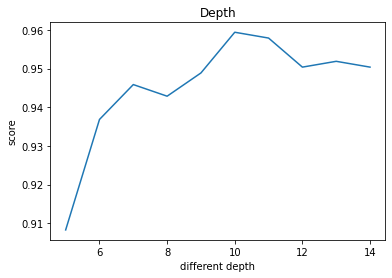

the minimun best depth is 10.0, the corresponding socre is 0.9593984962406015


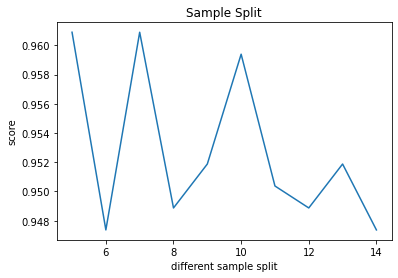

the minimun best sample split is 5.0, the corresponding socre is 0.9609022556390977


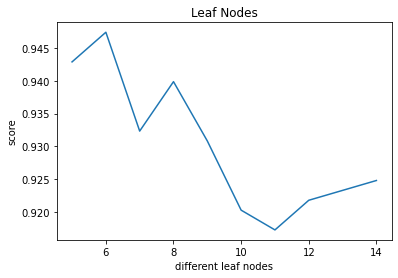

the minimun best leaves is 6.0, the corresponding socre is 0.9473684210526315
MY


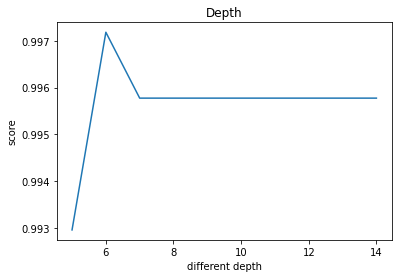

the minimun best depth is 6.0, the corresponding socre is 0.9971830985915492


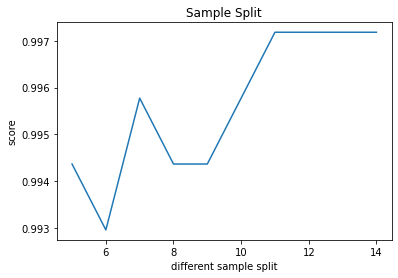

the minimun best sample split is 11.0, the corresponding socre is 0.9971830985915492


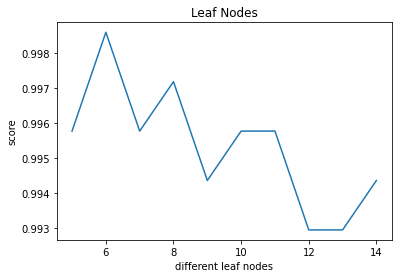

the minimun best leaves is 6.0, the corresponding socre is 0.9985915492957746
ZJ


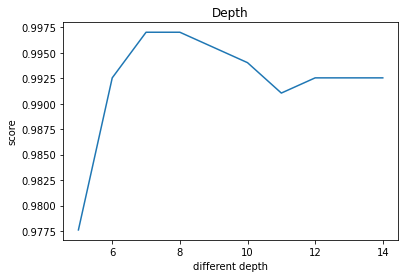

the minimun best depth is 7.0, the corresponding socre is 0.9970149253731343


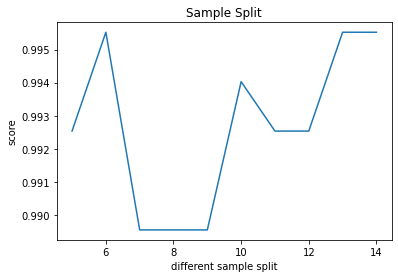

the minimun best sample split is 6.0, the corresponding socre is 0.9955223880597014


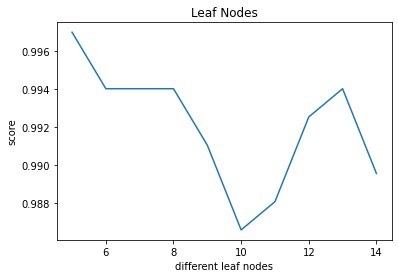

the minimun best leaves is 5.0, the corresponding socre is 0.9970149253731343


In [ ]:

if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["HK", "MY", "ZJ"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        X = [i[1:] for i in total_list]
        y = [i[0] for i in total_list]

        X_test = [i[1:] for i in test_list]
        y_test = [i[0] for i in test_list]

        X, y = X, y

        global cv
        cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=10)

         # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        

        # para, score = RTClassifier(X, y)
        # print(para, score)


In [ ]:
# Test
import time

score_lst = []

label_lst = ["HK", "MY", "ZJ"]
depth_lst = [10, 6, 7]
sample_lst = [5, 11, 6]
leaf_lst = [6, 6, 5]

for i in range(0, 3):
    start_time = time.time()
    label = label_lst[i]
    print(label)
    
    depth = depth_lst[i]
    sample = sample_lst[i]
    leaf = leaf_lst[i]
    
    RFC_model = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=sample, min_samples_leaf=leaf,
                                       random_state=10)
    RFC_model.fit(X, y)
    score = RFC_model.score(X_test, y_test)
    
    score_lst.append(score)
    end_time = time.time()
    duration = start_time - end_time
    print(duration)


print(score_lst)



HK
-0.024417400360107422
MY
-0.023075342178344727
ZJ
-0.021342992782592773
[0.9798657718120806, 0.9731543624161074, 0.9798657718120806]


## Decision Tree

In [ ]:
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
        i[0] = label_map[i[0]]

    return data_list

def dataset(data_list):
    X = np.array([i[1:] for i in data_list])
    y = np.array([i[0] for i in data_list])
    return X, y


def set_indicator(X, y, indicate):
    global cv
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
    decision_tree = tree.DecisionTreeClassifier(criterion=indicate, random_state=10)
    score = cross_val_score(decision_tree, X, y, cv=cv).mean()

    return score

def set_depth(X, y):
    score_lst = []

    for i in range(5, 15):
        decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=10)
        score = cross_val_score(decision_tree, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)
    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(score[:, 0], score[:, 1])
    # plt.show()

    return score, max_score

def set_split(X, y, depth):
    score_lst = []

    for i in range(5, 15):
        decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_split=i, random_state=10)
        score = cross_val_score(decision_tree, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)

    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score, max_score

def set_leaf(X, y, depth, sample):
    score_lst = []

    for i in range(5, 15):
        decision_tree = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, max_depth=depth, min_samples_split=sample,
                                          random_state=10)
        score = cross_val_score(decision_tree, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score_lst = np.array(score_lst)

    max_score = np.where(score_lst == np.max(score_lst[:, 1]))[0][0]  # 找出最高得分对应的索引

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score_lst, max_score

def set_combine(X, y):

    param_grid = {
        'max_depth': np.arange(5, 15),
        'min_samples_split': np.arange(5, 15),
        'min_samples_leaf': np.arange(5, 15)}

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=10)

    decision_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=10)
    tree_model = GridSearchCV(decision_tree, param_grid, cv=cv)
    tree_model.fit(X, y)
    return tree_model.best_params_, tree_model.best_score_


HK
the entropy score is 0.9426415094339623, the gini socre is 0.9373584905660378


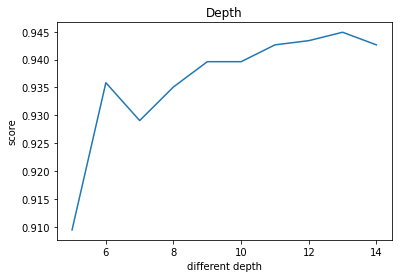

the minimun best depth is 13.0, the corresponding socre is 0.9449056603773585


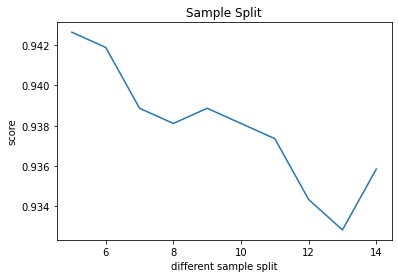

the minimun best sample split is 5.0, the corresponding socre is 0.9426415094339623


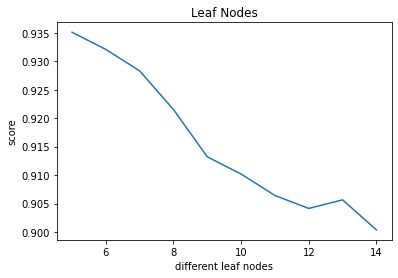

the minimun best leaves is 5.0, the corresponding socre is 0.9350943396226417
MY
the entropy score is 0.9929577464788732, the gini socre is 0.9943661971830984


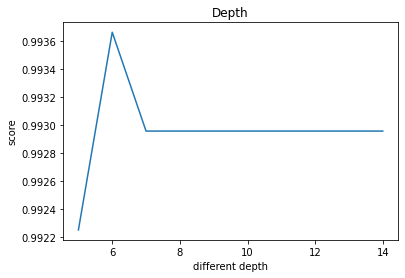

the minimun best depth is 6.0, the corresponding socre is 0.9936619718309858


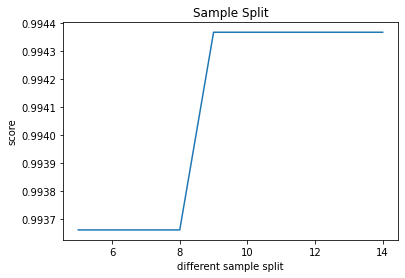

the minimun best sample split is 9.0, the corresponding socre is 0.9943661971830986


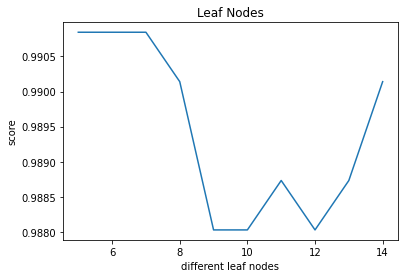

the minimun best leaves is 5.0, the corresponding socre is 0.9908450704225352
ZJ
the entropy score is 0.9850187265917603, the gini socre is 0.9827715355805242


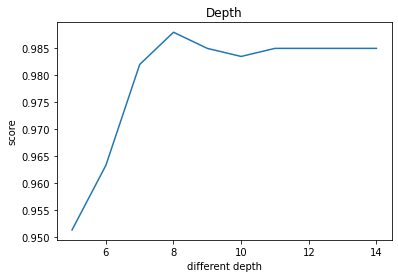

the minimun best depth is 8.0, the corresponding socre is 0.9880149812734083


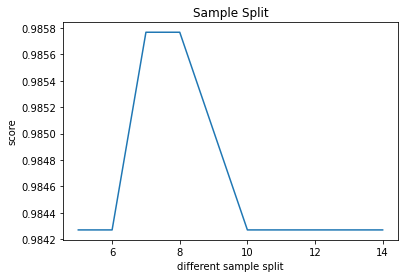

the minimun best sample split is 7.0, the corresponding socre is 0.9857677902621724


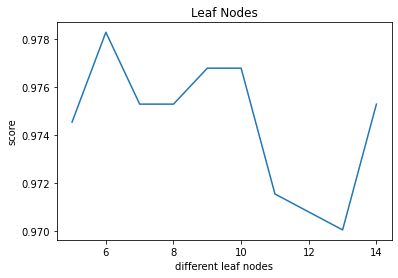

the minimun best leaves is 6.0, the corresponding socre is 0.9782771535580524


In [ ]:

if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["HK", "MY", "ZJ"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        X = [j[1:] for j in total_list]
        y = [j[0] for j in total_list]

        X_test = [i[1:] for i in test_list]
        y_test = [i[0] for i in test_list]

        # different indicator
        en_score = set_indicator(X, y, 'entropy')
        gini_socre = set_indicator(X, y, 'gini')
        print(f"the entropy score is {en_score}, the gini socre is {gini_socre}")

        # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        # para, socre = set_combine(X, y)
        # print(f"the best parameters of this decision tree is {para}, the corresponding socre is {socre}")

        # break





In [ ]:
# Test
import time

score_lst = []

label_lst = ["HK", "MY", "ZJ"]
depth_lst = [13, 6, 8]
sample_lst = [5, 9, 7]
leaf_lst = [5, 5, 6]

for i in range(0, 3):
    start_time = time.time()
    label = label_lst[i]
    print(label)
    
    depth = depth_lst[i]
    sample = sample_lst[i]
    leaf = leaf_lst[i]
    
    decision_tree = tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=sample, min_samples_leaf=leaf,
                                       random_state=10)
    decision_tree.fit(X, y)
    score = decision_tree.score(X_test, y_test)
    
    score_lst.append(score)
    end_time = time.time()
    duration = start_time - end_time
    print(duration)

print(score_lst)




HK
-0.010430335998535156
MY
-0.005440950393676758
ZJ
-0.0054776668548583984
[0.9664429530201343, 0.9664429530201343, 0.9798657718120806]


# Multi-Class

In [ ]:
# initialize the data

def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 2, 'Y': 3, 'Z': 4, 'J': 5}

    for i in data_list:
      # print(i[0])
      i[0] = label_map[i[0]]
    
    return data_list

train_dict, test_dict = data_process()

label = "all_data"
total_list = train_dict[label]
test_list = test_dict[label]

total_list = map_label(total_list)
print(total_list)
test_list = map_label(test_list)

X = [i[1:] for i in total_list]
y = [i[0] for i in total_list]

[[5, 6, 13, 5, 10, 4, 7, 10, 2, 3, 13, 5, 5, 2, 8, 7, 8], [5, 3, 7, 5, 8, 5, 9, 8, 4, 4, 7, 6, 9, 3, 7, 8, 6], [0, 3, 8, 4, 5, 2, 7, 7, 15, 1, 7, 6, 8, 3, 8, 0, 8], [1, 4, 8, 6, 6, 4, 5, 6, 1, 7, 10, 9, 11, 4, 7, 4, 7], [0, 3, 1, 4, 2, 3, 7, 7, 6, 6, 7, 6, 8, 3, 8, 4, 8], [0, 5, 5, 6, 6, 3, 7, 5, 15, 1, 7, 8, 8, 3, 8, 0, 8], [0, 3, 4, 4, 5, 2, 7, 9, 15, 2, 7, 3, 8, 3, 8, 0, 8], [1, 4, 5, 7, 4, 4, 6, 7, 2, 7, 10, 7, 10, 3, 8, 3, 8], [1, 6, 9, 9, 7, 10, 7, 7, 4, 4, 6, 6, 9, 8, 8, 8, 8], [4, 5, 10, 6, 8, 4, 8, 7, 6, 12, 7, 6, 7, 1, 8, 8, 8], [2, 2, 3, 4, 2, 2, 7, 7, 3, 3, 9, 8, 8, 5, 5, 1, 7], [3, 5, 8, 5, 6, 2, 3, 11, 2, 7, 12, 11, 6, 1, 10, 2, 5], [0, 5, 10, 7, 8, 10, 8, 9, 5, 3, 6, 7, 7, 7, 9, 9, 8], [5, 2, 7, 3, 5, 1, 14, 2, 6, 5, 14, 2, 11, 0, 7, 0, 8], [3, 3, 5, 5, 4, 2, 7, 11, 1, 8, 6, 11, 8, 1, 11, 2, 8], [0, 7, 11, 10, 8, 9, 9, 7, 3, 6, 10, 4, 7, 5, 6, 4, 9], [2, 5, 11, 6, 9, 4, 8, 7, 12, 2, 6, 9, 8, 9, 6, 0, 8], [0, 5, 10, 7, 8, 7, 8, 8, 7, 6, 7, 6, 7, 3, 8, 3, 7], [2, 4, 1, 5, 

### ANN

In [ ]:
class ArtiModel(nn.Module):
    def __init__(self):
        super(ArtiModel, self).__init__()
        self.hidden1 = nn.Linear(16, 12)
        self.hidden2 = nn.Linear(12, 8)
        self.fc1 = nn.Linear(8, 6)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.fc1(x)

        return x


def dataset(data_list):
    X = torch.tensor(np.array([i[1:] for i in data_list])).type(torch.FloatTensor)
    y = torch.tensor(np.array([i[0] for i in data_list])).type(torch.LongTensor)
    return X, y


def train(X, y, model, epoch):
    global optimizer
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0001)
    global loss_func
    loss_func = torch.nn.CrossEntropyLoss()

    t0 = time.time_ns()
    train_loss = 0

    for i in range(epoch):
        y_hat = model(X)
        # print(y_hat.shape)
        # print(y.shape)
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if i % 1000 == 0:
            print("step =", i, "loss =", loss.item())

    t1 = time.time_ns()
    total_time = t1-t0

    train_loss /= len(X)

    return train_loss, total_time

def test(X, y, model):
    model.eval()
    test_loss = 0
    acc = 0
    with torch.no_grad():
        y_hat = model(X)
        optimizer.zero_grad()
        test_loss += loss_func(y_hat, y).item()
        pred = y_hat.max(1, keepdim=True)[1]
        acc += pred.eq(y.view_as(pred)).sum().item()

        test_loss /= len(X)
        acc /= len(X)

    return acc


In [ ]:
epoch = 2000
kf = KFold(n_splits=5, random_state=10, shuffle=True)

for train_index, valid_index in kf.split(total_list):
    train_list = np.array(total_list)[train_index]
    valid_list = np.array(total_list)[valid_index]

    X_train, y_train = dataset(train_list)
    # y_train = y_train.reshape(len(y_train), 1)
    X_val, y_val = dataset(valid_list)
            

    # model = ArtiModel().to(device)
    model = ArtiModel()
    acc_lst = []

    # X_train, y_train  = X_train.to(device), y_train.to(device)
    # X_val, y_val = X_val.to(device), y_val.to(device)

    loss, total_time = train(X_train, y_train, model, epoch)
    acc = test(X_val, y_val, model)
    acc_lst.append(acc)
        
    model_file = '/content/drive/MyDrive/514_programming_2/model/Adam/' + label + "_para.pkl"

    # torch.save(model.state_dict(), model_file)
print("acc:", np.mean(acc_lst))

# 0.9177914110429448, 0.9619631901840491, 0.9656441717791411

step = 0 loss = 2.0257232189178467
step = 1000 loss = 0.06894119083881378
step = 0 loss = 2.116682529449463
step = 1000 loss = 0.06669862568378448
step = 0 loss = 2.0869014263153076
step = 1000 loss = 0.11737524718046188
step = 0 loss = 1.8805123567581177
step = 1000 loss = 0.09318630397319794
step = 0 loss = 1.8456107378005981
step = 1000 loss = 0.05227045714855194
acc: 0.9656441717791411


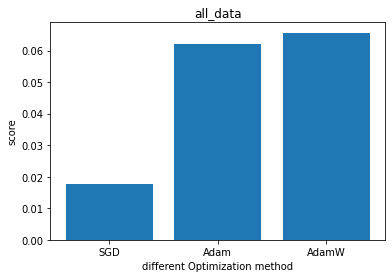

In [ ]:
# plot
import matplotlib.pyplot as plt
%matplotlib inline

label_lst = ["all_data"]

Score_feature = [[0.9177914110429448, 0.9619631901840491, 0.9656441717791411]]
deal_lst = [[i-0.9 for i in j] for j in Score_feature]

# print(deal_lst)
method_lst = ["SGD", "Adam", "AdamW"]

for i in range(0, 1):
  # print(i)
  label = label_lst[i]
  X = np.array(deal_lst[i])
  y = np.array(method_lst)
  plt.bar(y, X)
  plt.title(label)
  plt.xlabel('different Optimization method')
  plt.ylabel('score')
  plt.show()

In [ ]:
import time

train_dict, test_dict = data_process()
label_lst = ["all_data"]
Accuracy = {}
for i in label_lst:
    start_time = time.time()
    acc=0
    label = i
    print(label)

    checkpoint_file = '/content/drive/MyDrive/514_programming_2/model/Adam/' + label + "_para.pkl"
    checkpoint = torch.load(checkpoint_file) 
    model.load_state_dict(checkpoint)

    train_dict, test_dict = data_process()
    test_list = test_dict[label]
    test_list = map_label(test_list)
    test_list = np.array(test_list)

    X_test, y_test = dataset(test_list)
    # X_test, y_test = X_test.to(device), y_test.to(device)
    acc = test(X_test, y_test, model)

    Accuracy[label] = acc
    end_time = time.time()

duration = end_time - start_time
print(duration)
print(Accuracy)
# AdamW {'all_data': 0.9604395604395605}
# Adam  {'all_data': 0.9648351648351648}
# SGD   {'all_data': 0.9516483516483516}


### KNN

all_data


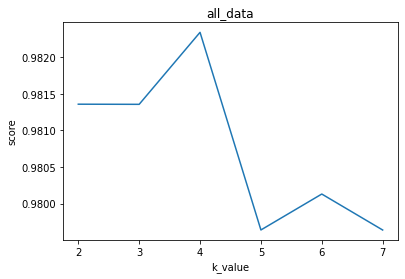

The best K is ： 4


In [ ]:
if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["all_data"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        kf = KFold(n_splits=5, random_state=10, shuffle=True)
        cross_score_lst = []
        k_lst = []

        for k in range(2, 8):
            scores_lst = []
            for train_index, valid_index in kf.split(total_list):
                train_list = np.array(total_list)[train_index]
                valid_list = np.array(total_list)[valid_index]

                X_train, y_train = dataset(train_list)
                X_val, y_val = dataset(valid_list)

                knn = KNN(k=k, X=X_train, y=y_train)
                cross_score = knn.fit(X_val, y_val)
                scores_lst.append(cross_score)
                # print(cross_score)
            score_mean = np.mean(scores_lst)
            cross_score_lst.append(score_mean)
            k_lst.append(k)


        k = np.array(k_lst)
        scores = np.array(cross_score_lst)
        plt.plot(k, scores)
        plt.title(label)
        plt.xlabel('k_value')
        plt.ylabel('score')
        plt.show()
        max_idx = scores.argmax()
        max_k = k_lst[max_idx]
        print('The best K is ：', max_k)


In [ ]:
import time


if __name__ == '__main__':

    train_dict, test_dict = data_process()

    label_lst = ["all_data"]
    best_key = [4]
    label_dict = {}
    for i in range(0, 1):
        start_time = time.time()

        label = label_lst[i]
        k = best_key[i]
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        k_lst = []

        X_test, y_test = dataset(test_list)
        X_train, y_train = dataset(total_list)

        knn = KNN(k=k, X=X_train, y=y_train)
        score = knn.fit(X_test, y_test)
    
        end_time = time.time()

        duration = end_time - start_time
        
        print(duration)
        print(score)
"""
all_data
19.054044723510742
0.9736263736263736
"""

all_data
18.558144092559814
0.978021978021978


'\nall_data\n19.054044723510742\n0.9736263736263736\n'

### Random Forest

all_data


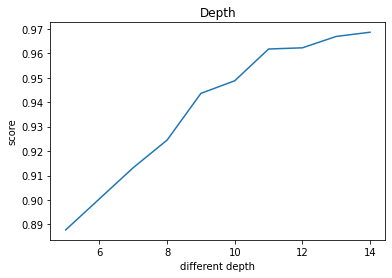

the minimun best depth is 14.0, the corresponding socre is 0.9686274509803923


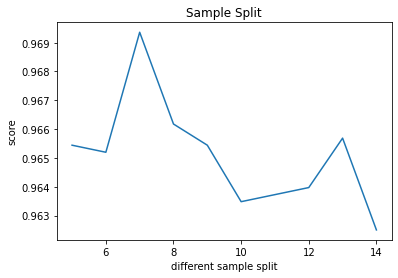

the minimun best sample split is 7.0, the corresponding socre is 0.9693627450980392


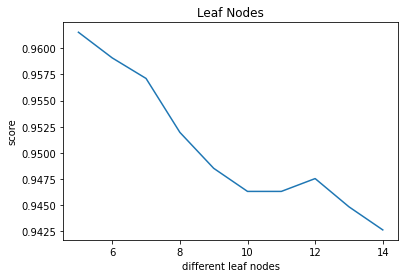

the minimun best leaves is 5.0, the corresponding socre is 0.9615196078431373


In [ ]:

if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["all_data"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        X = [i[1:] for i in total_list]
        y = [i[0] for i in total_list]

        X, y = X, y

         # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        global cv
        cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=10)

        # para, score = RTClassifier(X, y)
        # print(para, score)


In [ ]:
# Test
import time

score_lst = []

label_lst = ["all_data"]
depth_lst = [14]
sample_lst = [7]
leaf_lst = [5]

for i in range(0, 1):
    start_time = time.time()
    label = label_lst[i]
    print(label)
    
    depth = depth_lst[i]
    sample = sample_lst[i]
    leaf = leaf_lst[i]
    
    RFC_model = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=sample, min_samples_leaf=leaf,
                                       random_state=10)
    RFC_model.fit(X_test, y_test)
    score = RFC_model.score(X_test, y_test)
    
    score_lst.append(score)
    end_time = time.time()
    duration = start_time - end_time
    print(duration)


print(score_lst)



all_data
-0.028037071228027344
[0.9530201342281879]


### Decision Tree

all_data


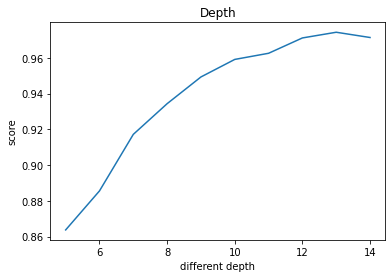

the minimun best depth is 13.0, the corresponding socre is 0.9742647058823529


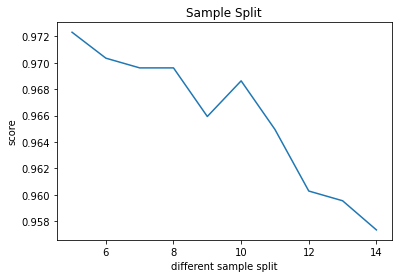

the minimun best sample split is 5.0, the corresponding socre is 0.9723039215686274


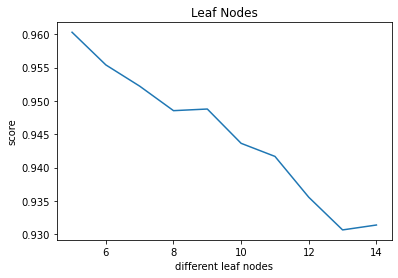

the minimun best leaves is 5.0, the corresponding socre is 0.9602941176470589


In [ ]:

if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["all_data"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        X = [j[1:] for j in total_list]
        y = [j[0] for j in total_list]

        # different indicator
        en_score = set_indicator(X, y, 'entropy')
        gini_socre = set_indicator(X, y, 'gini')
        # print(f"the entropy score is {en_score}, the gini socre is {gini_socre}")

        # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        # para, socre = set_combine(X, y)
        # print(f"the best parameters of this decision tree is {para}, the corresponding socre is {socre}")

        # break

In [ ]:
# Test
import time

score_lst = []

label_lst = ["all_data"]
depth_lst = [13]
sample_lst = [5]
leaf_lst = [5]

for i in range(0, 1):
    start_time = time.time()
    label = label_lst[i]
    print(label)
    
    depth = depth_lst[i]
    sample = sample_lst[i]
    leaf = leaf_lst[i]
    
    decision_tree = tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=sample, min_samples_leaf=leaf,
                                       random_state=10)
    decision_tree.fit(X, y)
    score = decision_tree.score(X_test, y_test)
    
    score_lst.append(score)
    end_time = time.time()
    duration = start_time - end_time
    print(duration)

print(score_lst)


# Dimension Reduction

### Decision Tree

In [7]:
import numpy as np
import random
import json



def read_data(file, x, y):
    data_lst = []
    lines = file.split('\n')
       

    for line in lines:
        row = [line.split(',')[0]]
        num = [int(line.split(',')[i]) for i in range(1, len(line.split(',')))]
        # low_num = pca.fit_transform(num)
        row.extend(num)
        if row[0] == x or row[0] == y:
            data_lst.append(row)

    # data_lst = np.array(data_lst)  
    # print(data_lst[:,1:])         
    data_length = int(len(data_lst) * 0.9)
    train_data = data_lst[0:data_length]
    test_data = data_lst[data_length:]
    return train_data, test_data


def data_process():
    with open('/content/drive/MyDrive/514_programming_2/data/letter-recognition.data') as f:
        file = f.read()

    train_dict = {}
    test_dict = {}
    all_train = []
    all_test = []

    label_lst = ["H", "M", "Z", "K", "Y", "J"]
    for i in range(0, len(label_lst)//2):
        label = label_lst[i] + label_lst[i+3]
        train_dict[label], test_dict[label] = read_data(file, label_lst[i], label_lst[i+3])
        all_train.extend(train_dict[label])
        all_test.extend(test_dict[label])

    random.shuffle(all_train)
    random.shuffle(all_test)

    train_dict['all_data'] = all_train
    test_dict['all_data'] = all_test

    return train_dict, test_dict

train_dict, test_dict = data_process()
# print(train_dict)


In [8]:
def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
        i[0] = label_map[i[0]]

    return data_list

In [13]:
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import numpy as np



def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
        i[0] = label_map[i[0]]

    return data_list

def set_indicator(X, y, indicate):
    global cv
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=10)
    decision_tree = tree.DecisionTreeClassifier(criterion=indicate, random_state=10)
    score = cross_val_score(decision_tree, X, y, cv=cv).mean()

    return score

def set_depth(X, y):
    score_lst = []

    for i in range(5, 50):
        decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=10)
        score = cross_val_score(decision_tree, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)
    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(score[:, 0], score[:, 1])
    # plt.show()

    return score, max_score

def set_split(X, y, depth):
    score_lst = []

    for i in range(5, 50):
        decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_split=i, random_state=10)
        score = cross_val_score(decision_tree, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)

    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score, max_score

def set_leaf(X, y, depth, sample):
    score_lst = []

    for i in range(5, 50):
        decision_tree = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, max_depth=depth, min_samples_split=sample,
                                          random_state=10)
        score = cross_val_score(decision_tree, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score_lst = np.array(score_lst)

    max_score = np.where(score_lst == np.max(score_lst[:, 1]))[0][0]  # 找出最高得分对应的索引

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score_lst, max_score

def set_combine(X, y):

    param_grid = {
        'max_depth': np.arange(5, 15),
        'min_samples_split': np.arange(5, 15),
        'min_samples_leaf': np.arange(5, 15)}

    decision_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=10)
    tree_model = GridSearchCV(decision_tree, param_grid, cv=cv)
    tree_model.fit(X, y)
    return tree_model.best_params_, tree_model.best_score_


HK
the entropy score is 0.8706766917293234, the gini socre is 0.8676691729323307


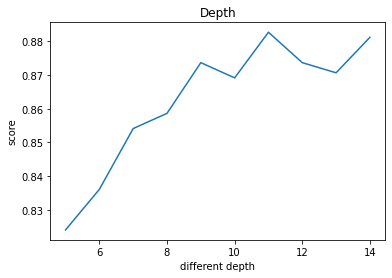

the minimun best depth is 11.0, the corresponding socre is 0.8827067669172932


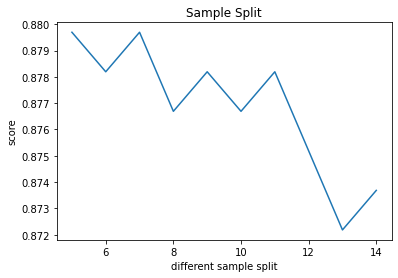

the minimun best sample split is 5.0, the corresponding socre is 0.8796992481203008


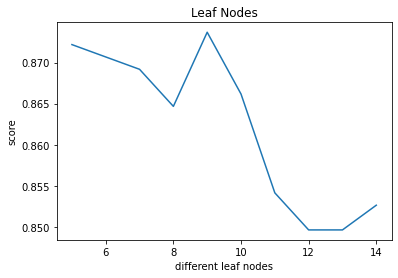

the minimun best leaves is 9.0, the corresponding socre is 0.8736842105263157
MY
the entropy score is 0.9732394366197183, the gini socre is 0.980281690140845


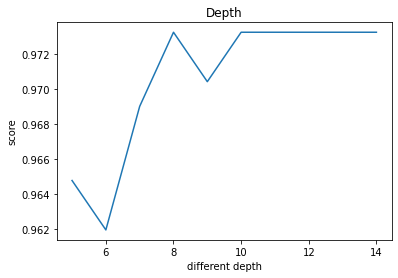

the minimun best depth is 8.0, the corresponding socre is 0.9732394366197183


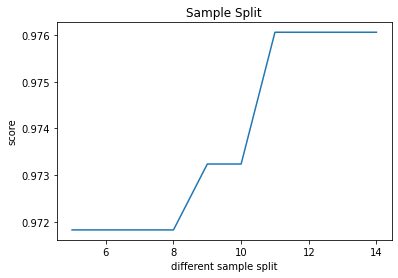

the minimun best sample split is 11.0, the corresponding socre is 0.976056338028169


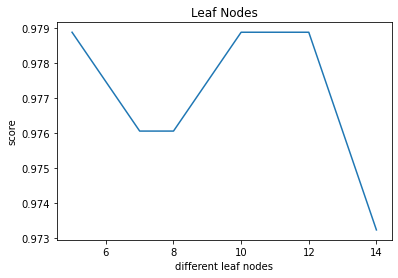

the minimun best leaves is 5.0, the corresponding socre is 0.9788732394366197
ZJ
the entropy score is 0.9597014925373134, the gini socre is 0.9522388059701493


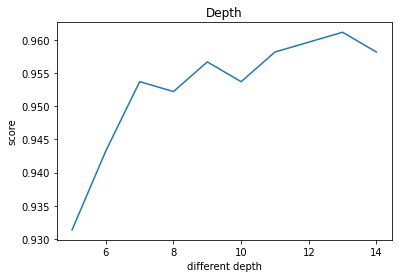

the minimun best depth is 13.0, the corresponding socre is 0.9611940298507463


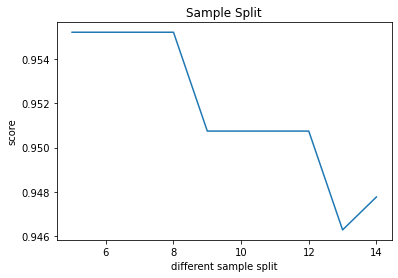

the minimun best sample split is 5.0, the corresponding socre is 0.955223880597015


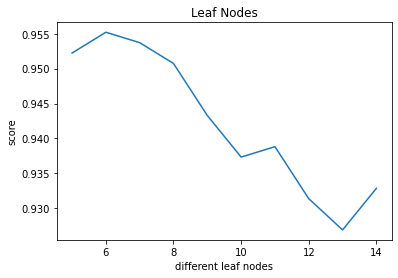

the minimun best leaves is 6.0, the corresponding socre is 0.955223880597015


In [ ]:
from sklearn.decomposition import PCA 


if __name__ == '__main__':
    train_dict, test_dict = data_process()
    pca = PCA(n_components=4)

    label_lst = ["HK", "MY", "ZJ"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        Original_total_list = map_label(total_list)
        Original_test_list = map_label(test_list)

        total_label = np.array(Original_total_list)[:, 0].reshape(-1, 1)
        test_label = np.array(Original_test_list)[:, 0].reshape(-1, 1)

        split_total_list = np.array(Original_total_list)[:, 1:]
        split_test_list = np.array(Original_test_list)[:, 1:]

        reduced_total_label = pca.fit_transform(split_total_list)
        reduced_test_list = pca.fit_transform(split_test_list)

        total_list = list(np.concatenate((total_label, reduced_total_label), axis=1))
        test_list = list(np.concatenate((test_label, reduced_test_list), axis=1))

        X = [j[1:] for j in total_list]
        y = [j[0] for j in total_list]

        X_test = [j[1:] for j in test_list]
        y_test = [j[0] for j in test_list]

        # different indicator
        en_score = set_indicator(X, y, 'entropy')
        gini_socre = set_indicator(X, y, 'gini')
        print(f"the entropy score is {en_score}, the gini socre is {gini_socre}")

        # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        # para, socre = set_combine(X, y)
        # print(f"the best parameters of this decision tree is {para}, the corresponding socre is {socre}")

        # break



all_data


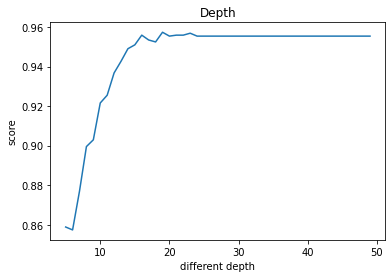

the minimun best depth is 19.0, the corresponding socre is 0.9573529411764706


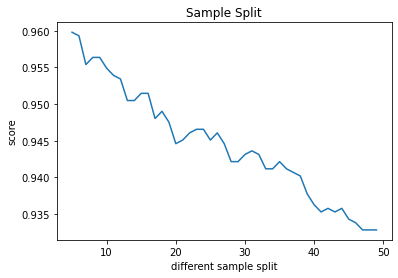

the minimun best sample split is 5.0, the corresponding socre is 0.9598039215686274


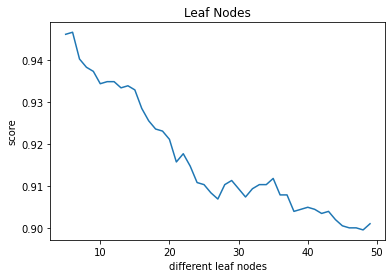

the minimun best leaves is 6.0, the corresponding socre is 0.9465686274509805


In [14]:

if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["all_data"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        X = [j[1:] for j in total_list]
        y = [j[0] for j in total_list]

        # different indicator
        en_score = set_indicator(X, y, 'entropy')
        gini_socre = set_indicator(X, y, 'gini')
        # print(f"the entropy score is {en_score}, the gini socre is {gini_socre}")

        # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        # para, socre = set_combine(X, y)
        # print(f"the best parameters of this decision tree is {para}, the corresponding socre is {socre}")

        # break

In [ ]:
# Test
import time


score_lst = []

label_lst = ["HK", "MY", "ZJ"]
depth_lst = [11, 8, 13]
sample_lst = [5, 11, 5]
leaf_lst = [9, 5, 6]

for i in range(0, 3):
    start_time = time.time()
    label = label_lst[i]
    print(label)
    
    depth = depth_lst[i]
    sample = sample_lst[i]
    leaf = leaf_lst[i]
    
    decision_tree = tree.DecisionTreeClassifier(max_depth=depth, min_samples_split=sample, min_samples_leaf=leaf,
                                       random_state=10)
    decision_tree.fit(X_test, y_test)
    score = decision_tree.score(X_test, y_test)
    
    score_lst.append(score)
    end_time = time.time()
    duration = start_time - end_time
    print(duration)

print(score_lst)




HK
-0.004897356033325195
MY
-0.002704143524169922
ZJ
-0.00347900390625
[0.9261744966442953, 0.9463087248322147, 0.9328859060402684]


### Random Forest

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

def map_label(data_list):
    label_map = {'H': 0, 'K': 1, 'M': 0, 'Y': 1, 'Z': 0, 'J': 1}

    for i in data_list:
        i[0] = label_map[i[0]]

    return data_list


def dataset(data_list):
    X = np.array([i[1:] for i in data_list])
    y = np.array([i[0] for i in data_list])
    return X, y


def set_depth(X, y):
    score_lst = []

    for i in range(5, 15):
        RFC_model = RandomForestClassifier(n_estimators=10, max_depth=i, random_state=10)
        score = cross_val_score(RFC_model, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)
    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(score[:, 0], score[:, 1])
    # plt.show()

    return score, max_score

def set_split(X, y, depth):
    score_lst = []

    for i in range(5, 15):
        RFC_model = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=i, random_state=10)
        score = cross_val_score(RFC_model, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score = np.array(score_lst)

    max_score = np.where(score == np.max(score[:, 1]))[0][0]

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score, max_score

def set_leaf(X, y, depth, sample):
    score_lst = []

    for i in range(5, 15):
        RFC_model = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=sample, min_samples_leaf=i, random_state=10)
        score = cross_val_score(RFC_model, X, y, cv=cv).mean()
        score_lst.append([i, score])
    score_lst = np.array(score_lst)

    max_score = np.where(score_lst == np.max(score_lst[:, 1]))[0][0] 

    # plt.figure(figsize=[20, 5])
    # plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    # plt.show()

    return score_lst, max_score

def RTClassifier(X, y):

    param_grid = {
        'max_depth': np.arange(5, 15),
        'min_samples_split': np.arange(5, 15),
        'min_samples_leaf': np.arange(5, 15)}

    RFC_model = RandomForestClassifier(n_estimators=10)
    forest_model = GridSearchCV(RFC_model, param_grid, cv=cv)
    forest_model.fit(X, y)

    return forest_model.best_params_, forest_model.best_score_


HK


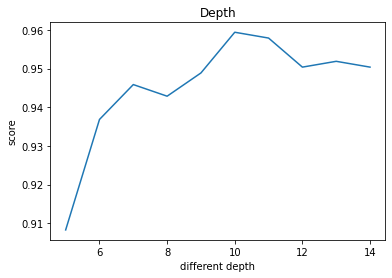

the minimun best depth is 10.0, the corresponding socre is 0.9593984962406015


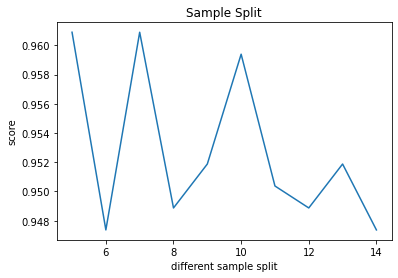

the minimun best sample split is 5.0, the corresponding socre is 0.9609022556390977


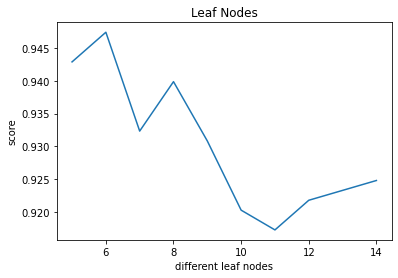

the minimun best leaves is 6.0, the corresponding socre is 0.9473684210526315
MY


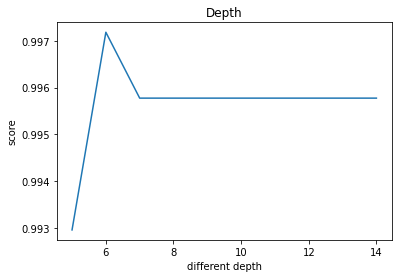

the minimun best depth is 6.0, the corresponding socre is 0.9971830985915492


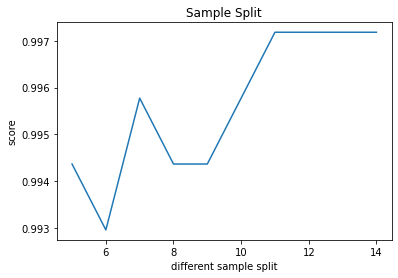

the minimun best sample split is 11.0, the corresponding socre is 0.9971830985915492


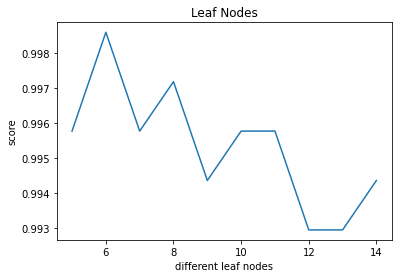

the minimun best leaves is 6.0, the corresponding socre is 0.9985915492957746
ZJ


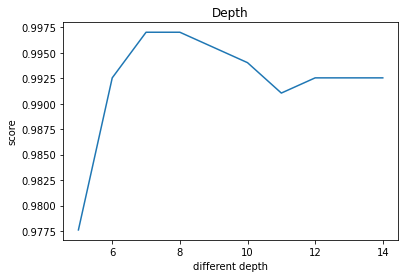

the minimun best depth is 7.0, the corresponding socre is 0.9970149253731343


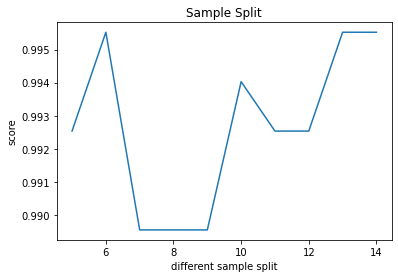

the minimun best sample split is 6.0, the corresponding socre is 0.9955223880597014


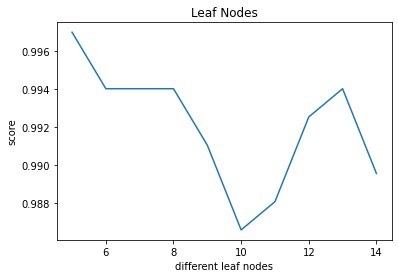

the minimun best leaves is 5.0, the corresponding socre is 0.9970149253731343


In [5]:

if __name__ == '__main__':
    global cv
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=10)
    train_dict, test_dict = data_process()

    label_lst = ["HK", "MY", "ZJ"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        X = [i[1:] for i in total_list]
        y = [i[0] for i in total_list]

        X, y = X, y

         # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        

        # para, score = RTClassifier(X, y)
        # print(para, score)


In [ ]:
# Test
import time

score_lst = []

label_lst = ["HK", "MY", "ZJ"]
depth_lst = [10, 6, 7]
sample_lst = [5, 11, 6]
leaf_lst = [6, 6, 5]

for i in range(0, 3):
    start_time = time.time()
    label = label_lst[i]
    print(label)
    
    depth = depth_lst[i]
    sample = sample_lst[i]
    leaf = leaf_lst[i]
    
    RFC_model = RandomForestClassifier(n_estimators=10, max_depth=depth, min_samples_split=sample, min_samples_leaf=leaf,
                                       random_state=10)
    RFC_model.fit(X, y)
    score = RFC_model.score(X_test, y_test)
    
    score_lst.append(score)
    end_time = time.time()
    duration = start_time - end_time
    print(duration)


print(score_lst)



HK
-0.04821944236755371
MY
-0.03706932067871094
ZJ
-0.03999757766723633
[0.9648351648351648, 0.9164835164835164, 0.9296703296703297]


all_data


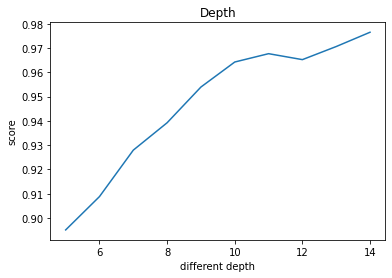

the minimun best depth is 14.0, the corresponding socre is 0.976470588235294


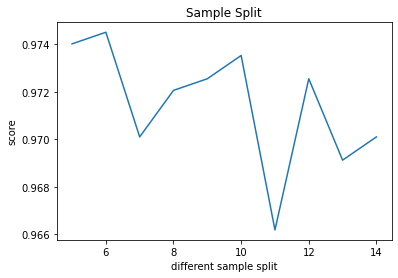

the minimun best sample split is 6.0, the corresponding socre is 0.9745098039215685


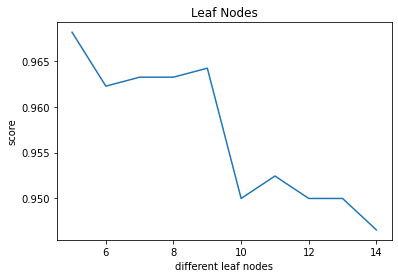

the minimun best leaves is 5.0, the corresponding socre is 0.9681372549019608


In [6]:

if __name__ == '__main__':
    train_dict, test_dict = data_process()

    label_lst = ["all_data"]
    label_dict = {}
    for i in label_lst:
        label = i
        print(label)

        total_list = train_dict[label]
        test_list = test_dict[label]

        total_list = map_label(total_list)
        test_list = map_label(test_list)

        X = [i[1:] for i in total_list]
        y = [i[0] for i in total_list]

        X, y = X, y

         # different depth
        dep_score, dep_max_score = set_depth(X, y)
        dep_index, dep_value = dep_score[dep_max_score][0], dep_score[dep_max_score][1]
        dep_y = np.array(dep_score)[:, 1]
        dep_x = np.array(dep_score)[:, 0]
        plt.plot(dep_x, dep_y)
        plt.title("Depth")
        plt.xlabel('different depth')
        plt.ylabel('score')
        plt.show()
        # print(dep_score)
        print(f"the minimun best depth is {dep_index}, the corresponding socre is {dep_value}")

        # different sample split
        split_score, split_max_score = set_split(X, y, dep_index)
        split_index, split_value = split_score[split_max_score][0], split_score[split_max_score][1]
        split_y = np.array(split_score)[:, 1]
        split_x = np.array(split_score)[:, 0]
        plt.plot(split_x, split_y)
        plt.title("Sample Split")
        plt.xlabel('different sample split')
        plt.ylabel('score')
        plt.show()
        # print(split_score)
        print(f"the minimun best sample split is {split_index}, the corresponding socre is {split_value}")

        # different leaf nodes
        sindex = int(split_index)
        leaf_score, leaf_max_score = set_leaf(X, y, dep_index, sindex)
        leaf_index, leaf_value = leaf_score[leaf_max_score][0], leaf_score[leaf_max_score][1]
        leaf_y = np.array(leaf_score)[:, 1]
        leaf_x = np.array(leaf_score)[:, 0]
        plt.plot(leaf_x, leaf_y)
        plt.title("Leaf Nodes")
        plt.xlabel('different leaf nodes')
        plt.ylabel('score')
        plt.show()
        # print(leaf_score)
        print(f"the minimun best leaves is {leaf_index}, the corresponding socre is {leaf_value}")

        global cv
        cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=10)

        # para, score = RTClassifier(X, y)
        # print(para, score)
